In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Closed data shape: (1400, 72, 72, 3)
Open data shape: (1501, 72, 72, 3)
Road data shape: (814, 72, 72, 3)
Closed data shape: (380, 72, 72, 3)
Open data shape: (363, 72, 72, 3)
Road data shape: (260, 72, 72, 3)
Training data shape: (3715, 72, 72, 3)
Training labels shape: (3715,)
Preprocessed training data shape: (3715, 72, 72)


<ipython-input-20-af3985ff1231>:73: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Test Accuracy: 36.59022931206381 %
F1 Score: 0.22748579927526957
Classification Report:
              precision    recall  f1-score   support

      Closed       0.44      0.03      0.06       380
        Open       0.36      0.96      0.53       363
        Road       0.42      0.03      0.06       260

    accuracy                           0.37      1003
   macro avg       0.41      0.34      0.21      1003
weighted avg       0.41      0.37      0.23      1003



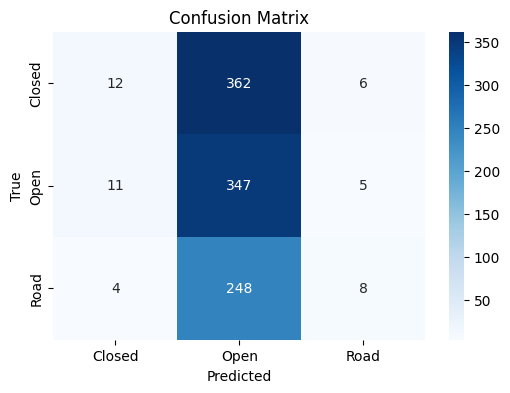

<ipython-input-20-af3985ff1231>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=f1_scores, palette='Blues')


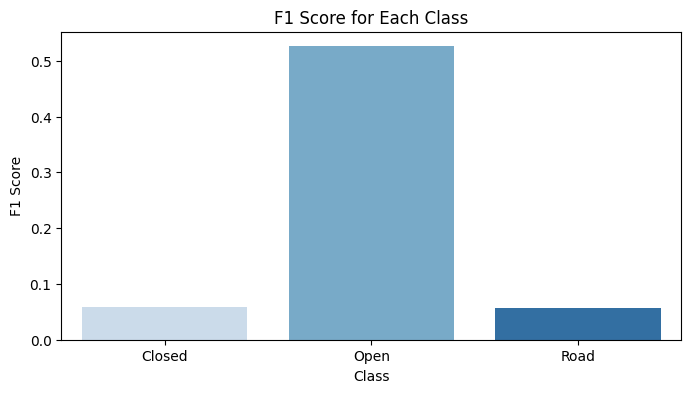

Epoch 1/10
93/93 [==============================] - 26s 231ms/step - loss: 1.0805 - accuracy: 0.3933 - val_loss: 1.0790 - val_accuracy: 0.3876
Epoch 2/10
93/93 [==============================] - 22s 241ms/step - loss: 1.0730 - accuracy: 0.4061 - val_loss: 1.0613 - val_accuracy: 0.3876
Epoch 3/10
93/93 [==============================] - 24s 263ms/step - loss: 1.0731 - accuracy: 0.4068 - val_loss: 1.0597 - val_accuracy: 0.4132
Epoch 4/10
93/93 [==============================] - 20s 220ms/step - loss: 1.0728 - accuracy: 0.3930 - val_loss: 1.0623 - val_accuracy: 0.3876
Epoch 5/10
93/93 [==============================] - 30s 326ms/step - loss: 1.0708 - accuracy: 0.4024 - val_loss: 1.0588 - val_accuracy: 0.3876
Epoch 6/10
93/93 [==============================] - 22s 239ms/step - loss: 1.0701 - accuracy: 0.3994 - val_loss: 1.0596 - val_accuracy: 0.3876
Epoch 7/10
93/93 [==============================] - 22s 238ms/step - loss: 1.0696 - accuracy: 0.4095 - val_loss: 1.0558 - val_accuracy: 0.3876

In [20]:
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns

# Function to load image data and labels(Train/Test)
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        if img is None:
            print(f"Warning: {file_} couldn't be read as an image.")
            continue  # Skip this file and move to the next
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, (72, 72), anti_aliasing=True)  # Resize every image to 72x72
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the entire training or test dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)

    # Debug: Print shapes of the data lists to ensure consistency
    print(f"Closed data shape: {np.array(closed_data).shape}")
    print(f"Open data shape: {np.array(open_data).shape}")
    print(f"Road data shape: {np.array(road_data).shape}")

    data = np.concatenate((closed_data, open_data, road_data), axis=0)
    labels = closed_label + open_label + road_label
    return np.array(data), np.array(labels)

data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')

print("Training data shape:", data_train.shape)
print("Training labels shape:", labels_train.shape)
# Function to preprocess images by converting to grayscale and resizing
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert the image to the correct data type and format
        img = arr[i].astype(np.uint8)  # Convert to 8-bit unsigned integer
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
print("Preprocessed training data shape:", data_train_p.shape)
# Function to extract HOG features from an image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr
# Function to preprocess the data by extracting HOG features
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature
# Preprocess the training and test data by extracting HOG features
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)
# Create and train the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(data_train_ftr, labels_train)
# Predict the labels for the test data and calculate accuracy
y_pred = random_forest.predict(data_test_ftr)
accuracy = accuracy_score(labels_test, y_pred)
print('Test Accuracy:', accuracy*100, "%")
# Calculate the F1 score
f1 = f1_score(labels_test, y_pred, average='weighted')
print('F1 Score:', f1)
# Create a classification report to show precision, recall, and F1 score for each class
class_names = np.unique(labels_test)
print('Classification Report:')
print(classification_report(labels_test, y_pred, target_names=class_names))
# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Create a bar plot to show the F1 score for each class
f1_scores = f1_score(labels_test, y_pred, average=None)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores, palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

labels_train_onehot = to_categorical(labels_train_encoded)
labels_test_onehot = to_categorical(labels_test_encoded)

# Convert data to 3D tensors
data_train_p = np.expand_dims(data_train_p, axis=-1)
data_test_p = np.expand_dims(data_test_p, axis=-1)

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(data_train_p, labels_train_onehot, test_size=0.2, random_state=42)

# Importing necessary libraries for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten

# Create BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(72, 72)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(data_test_p, labels_test_onehot)
print('Test Loss:', test_loss)
print('Test Accuracy (BiLSTM):', test_acc * 100, "%")


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/10
117/117 [==============================] - 32s 266ms/step - loss: 0.8500 - accuracy: 0.6011
Epoch 2/10
117/117 [==============================] - 37s 320ms/step - loss: 0.6514 - accuracy: 0.7257
Epoch 3/10
117/117 [==============================] - 31s 268ms/step - loss: 0.6210 - accuracy: 0.7279
Epoch 4/10
117/117 [==============================] - 45s 383ms/step - loss: 0.4808 - accuracy: 0.7984
Epoch 5/10
117/117 [==============================] - 43s 369ms/step - loss: 0.4086 - accuracy: 0.8326
Epoch 6/10
117/117 [==============================] - 45s 388ms/step - loss: 0.3288 - accuracy: 0.8678
Epoch 7/10
117/117 [==============================] - 31s 265ms/step - loss: 0.2676 - accuracy: 0.8958
Epoch 8/10
117/117 [==============================] - 41s 349ms/step - loss: 0.1971 - accuracy: 0.9260
Epoch 9/10
117/117 [==============================] - 31s 265ms/step - loss: 0.1464 - accuracy: 0.9491
Epoch 10/10
32/32 [==============================] - 2s 63ms/step - loss:

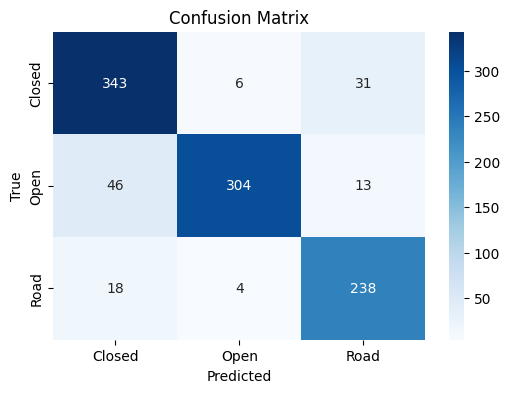

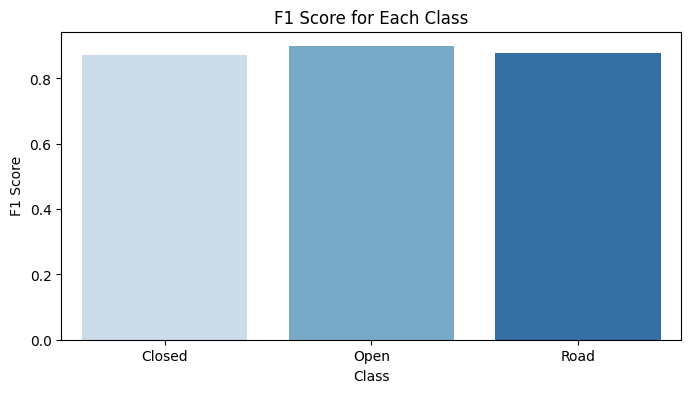

1/1 [==============================] - 0s 24ms/step


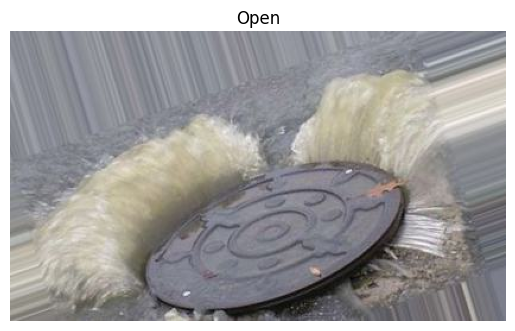

1/1 [==============================] - 0s 83ms/step


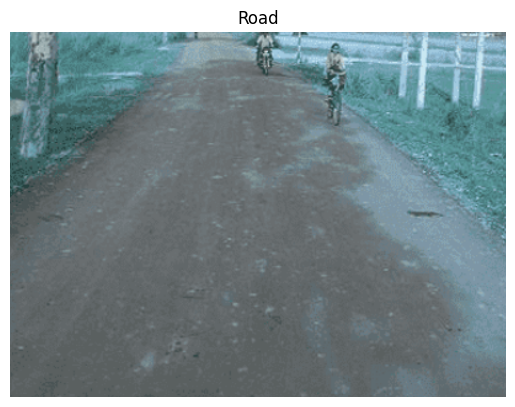

In [ ]:
 #cnn
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
from random import seed
from random import randint
# Function to load image data and labels for a specific fruit and type (Train/Test)
def load_data(manhole, tipo):
    # Initialize lists to store images and labels
    label = []
    arr = []
    # Fetch file paths for the given fruit and type using glob
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        # Read the image, convert it to RGB, and add it to the list
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        # Add the corresponding label to the label list
        label.append(manhole)
    return arr, label
# Function to load the entire training or test dataset
def whole_train_data(tipo):
    # Load data and labels for each category (Closed, Open, Road)
    closed_data, closed_label       = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    # Concatenate data and labels for all categories
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels
# Load the entire training dataset
data_train, labels_train = whole_train_data('Train')
# Load the entire test dataset
data_test, labels_test = whole_train_data('Test')
# Preprocessing function to convert images to grayscale and resize them
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert each image to grayscale
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep
# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
# Expand dimensions to represent single-channel (grayscale) images
data_train_p = np.expand_dims(data_train_p, axis=-1)
data_test_p = np.expand_dims(data_test_p, axis=-1)
# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 output classes (Closed, Open, Road)
    return model
# Define the input shape for the model
input_shape = (72, 72, 1)
# Create the CNN model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Encode the training and test labels using LabelEncoder and one-hot encoding
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)

labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)
# Train the model
model.fit(data_train_p, labels_train_one_hot, epochs=10, batch_size=32)
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc*100, "%")
# Predict the labels for the test data
y_pred = model.predict(data_test_p)
# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
labels_test_encoded = label_encoder.transform(labels_test)
# Calculate the F1 score
f1 = f1_score(labels_test_encoded, y_pred_labels, average='weighted')
print('F1 Score:', f1)
# Create a classification report to show precision, recall, and F1 score for each class
class_names = label_encoder.classes_
print('Classification Report:')
print(classification_report(labels_test_encoded, y_pred_labels, target_names=class_names))
# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test_encoded, y_pred_labels)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Create a bar plot to show the F1 score for each class
f1_scores = [f1_score(labels_test_encoded, y_pred_labels, average=None)]
f1_scores.sort(reverse=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores[0], palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_labels = model.predict(np.expand_dims(data_test_p[x_], axis=0))
predicted_label = np.argmax(predicted_labels)
predicted_manhole = label_encoder.inverse_transform([predicted_label])[0]
showImg(data_test[x_], predicted_manhole)
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
img = cv2.imread(image_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)
predicted_labels = model.predict(img_input)
predicted_label = np.argmax(predicted_labels)
predicted_manhole = label_encoder.inverse_transform([predicted_label])[0]
showImg(img, predicted_manhole)

Closed data shape: (1400, 72, 72, 3)
Open data shape: (1501, 72, 72, 3)
Road data shape: (814, 72, 72, 3)
Closed data shape: (380, 72, 72, 3)
Open data shape: (363, 72, 72, 3)
Road data shape: (260, 72, 72, 3)
Training data shape: (3715, 72, 72, 3)
Training labels shape: (3715,)
Preprocessed training data shape: (3715, 72, 72)


<ipython-input-10-ebf9e082bff4>:74: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Test Accuracy: 36.191425722831504 %
F1 Score: 0.22248015267381072
Classification Report:
              precision    recall  f1-score   support

      Closed       0.42      0.03      0.05       380
        Open       0.36      0.95      0.52       363
        Road       0.39      0.03      0.05       260

    accuracy                           0.36      1003
   macro avg       0.39      0.34      0.21      1003
weighted avg       0.39      0.36      0.22      1003



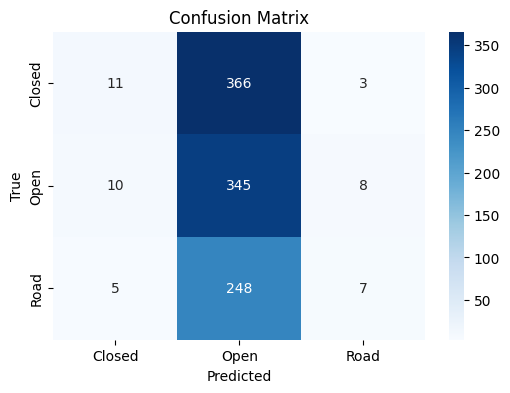

<ipython-input-10-ebf9e082bff4>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=f1_scores, palette='Blues')


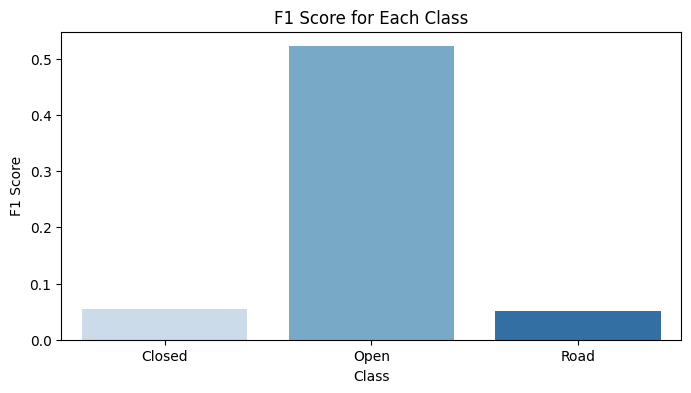

In [10]:
#random forest
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns

# Function to load image data and labels(Train/Test)
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        if img is None:
            print(f"Warning: {file_} couldn't be read as an image.")
            continue  # Skip this file and move to the next
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, (72, 72), anti_aliasing=True)  # Resize every image to 72x72
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the entire training or test dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)

    # Debug: Print shapes of the data lists to ensure consistency
    print(f"Closed data shape: {np.array(closed_data).shape}")
    print(f"Open data shape: {np.array(open_data).shape}")
    print(f"Road data shape: {np.array(road_data).shape}")

    data = np.concatenate((closed_data, open_data, road_data), axis=0)
    labels = closed_label + open_label + road_label
    return np.array(data), np.array(labels)

data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')

print("Training data shape:", data_train.shape)
print("Training labels shape:", labels_train.shape)
# Function to preprocess images by converting to grayscale and resizing
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert the image to the correct data type and format
        img = arr[i].astype(np.uint8)  # Convert to 8-bit unsigned integer
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
print("Preprocessed training data shape:", data_train_p.shape)
# Function to extract HOG features from an image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr
# Function to preprocess the data by extracting HOG features
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature
# Preprocess the training and test data by extracting HOG features
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)
# Create and train the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(data_train_ftr, labels_train)
# Predict the labels for the test data and calculate accuracy
y_pred = random_forest.predict(data_test_ftr)
accuracy = accuracy_score(labels_test, y_pred)
print('Test Accuracy:', accuracy*100, "%")
# Calculate the F1 score
f1 = f1_score(labels_test, y_pred, average='weighted')
print('F1 Score:', f1)
# Create a classification report to show precision, recall, and F1 score for each class
class_names = np.unique(labels_test)
print('Classification Report:')
print(classification_report(labels_test, y_pred, target_names=class_names))
# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Create a bar plot to show the F1 score for each class
f1_scores = f1_score(labels_test, y_pred, average=None)
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=f1_scores, palette='Blues')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.show()


Training data shape: (3715, 72, 72, 3)
Training labels shape: (3715,)
Preprocessed training data shape: (3715, 72, 72)


<ipython-input-12-4d4709da39dc>:66: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Test Accuracy: 38.2851445663011 %
F1 Score: 0.23679949543053783
Classification Report:
              precision    recall  f1-score   support

      Closed       0.38      0.97      0.55       380
        Open       0.48      0.03      0.06       363
        Road       0.44      0.02      0.03       260

    accuracy                           0.38      1003
   macro avg       0.43      0.34      0.21      1003
weighted avg       0.43      0.38      0.24      1003



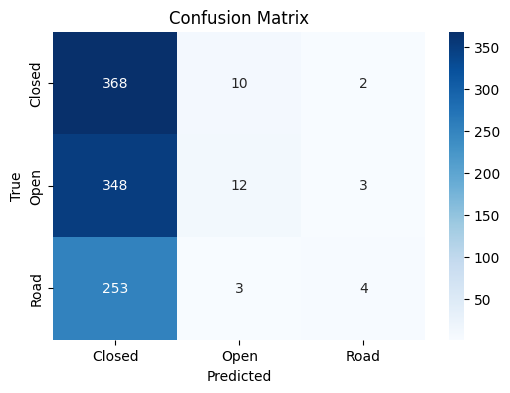

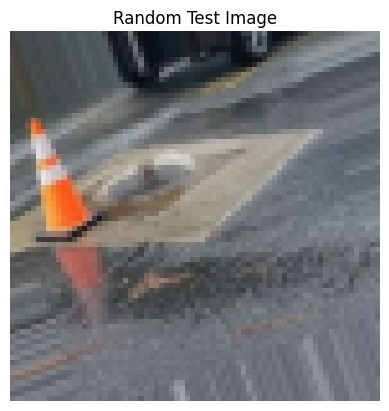

Predicted Label: Closed


In [12]:
#KNN
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import resize
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

# Function to load image data and labels for a specific fruit and type (Train/Test)
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        # Read the image, convert it to RGB, and resize it to a consistent size
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr.append(img)
        # Add the corresponding label to the label list
        label.append(manhole)
    return arr, label


# Function to load the entire training or test dataset
def whole_train_data(tipo):
    # Load data and labels for each category (Closed, Open, Road)
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    # Concatenate data and labels for all categories
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

# Load the entire training dataset
data_train, labels_train = whole_train_data('Train')
# Load the entire test dataset
data_test, labels_test = whole_train_data('Test')
print("Training data shape:", data_train.shape)
print("Training labels shape:", labels_train.shape)

def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert the image to the correct data type and format
        img = arr[i].astype(np.uint8)  # Convert to 8-bit unsigned integer
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep


# Preprocess the training data and test data
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
print("Preprocessed training data shape:", data_train_p.shape)

# Function to extract HOG features from an image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr

# Function to preprocess the data by extracting HOG features
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature

# Preprocess the training and test data by extracting HOG features
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)

# Create and train the K-Nearest Neighbors (KNN) Classifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(data_train_ftr, labels_train)

# Predict the labels for the test data and calculate accuracy
y_pred = knn_clf.predict(data_test_ftr)
accuracy = accuracy_score(labels_test, y_pred)
print('Test Accuracy:', accuracy*100,"%")

# Calculate the F1 score
f1 = f1_score(labels_test, y_pred, average='weighted')
print('F1 Score:', f1)

# Create a classification report to show precision, recall, and F1 score for each class
class_names = np.unique(labels_test)
print('Classification Report:')
print(classification_report(labels_test, y_pred, target_names=class_names))

# Create a confusion matrix
conf_matrix = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display random image prediction
from random import seed
from random import randint
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_label = knn_clf.predict([data_test_ftr[x_]])
predicted_manhole = predicted_label[0]
plt.imshow(data_test[x_])
plt.title('Random Test Image')
plt.axis('off')
plt.show()
print("Predicted Label:", predicted_manhole)

# Function to preprocess the image and make a prediction
def preprocess_and_predict_image(image_path, clf):
    # Read the image from the specified file path
    img = cv2.imread(image_path)

    if img is not None:
        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size (72x72)
        img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
        # Extract HOG features from the resized image
        img_ftr = ExtractHOG(img_resized)
        # Make the prediction using the provided classifier
        predicted_label = clf.predict([img_ftr])
        predicted_manhole = predicted_label[0]
        # Display the image and prediction
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Custom Test Image')
        plt.axis('off')
        plt.show()
        print("Predicted Label:", predicted_manhole)
    else:
        print("Failed to load the image from:", image_path)



<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Shape of data_train_p: (3715, 72, 72, 1)
Shape of labels_train_encoded: (3715,)
Epoch 1/10
117/117 [==============================] - 28s 225ms/step - loss: 0.8895 - accuracy: 0.5750
Epoch 2/10
117/117 [==============================] - 30s 251ms/step - loss: 0.6669 - accuracy: 0.7074
Epoch 3/10
117/117 [==============================] - 26s 218ms/step - loss: 0.5463 - accuracy: 0.7658
Epoch 4/10
117/117 [==============================] - 26s 219ms/step - loss: 0.4431 - accuracy: 0.8145
Epoch 5/10
117/117 [==============================] - 23s 200ms/step - loss: 0.3631 - accuracy: 0.8525
Epoch 6/10
117/117 [==============================] - 25s 218ms/step - loss: 0.2760 - accuracy: 0.8956
Epoch 7/10
117/117 [==============================] - 58s 501ms/step - loss: 0.2299 - accuracy: 0.9090
Epoch 8/10
117/117 [==============================] - 28s 240ms/step - loss: 0.1980 - accuracy: 0.9265
Epoch 9/10
117/117 [==============================] - 24s 201ms/step - loss: 0.1181 - accuracy: 

<ipython-input-11-22695c704f16>:82: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Ensemble Accuracy: 66.89930209371884 %
Ensemble F1 Score: 0.6667438866924777


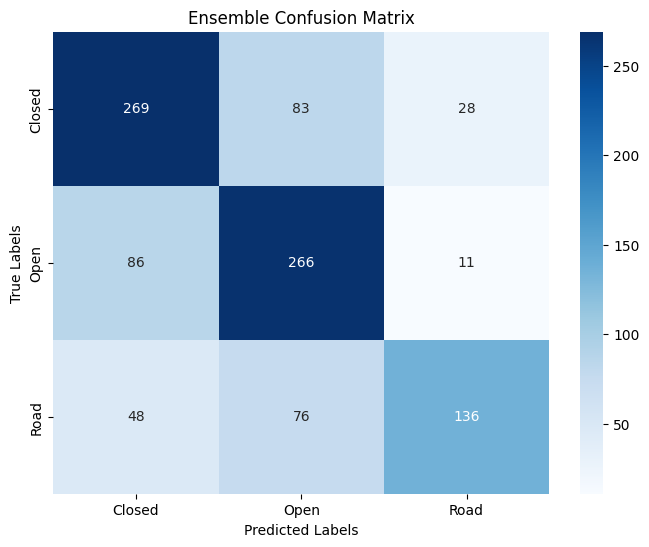

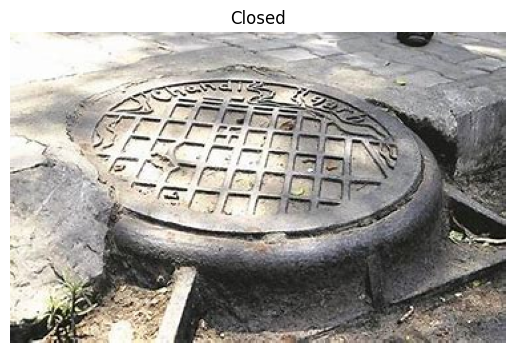

In [ ]:
"" #ensemble learning using stacking
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
# Load and preprocess the training data for CNN
def load_data(fruit, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+fruit+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(fruit)
    return arr, label
# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels
data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep
data_train_p = np.array(preprocessing(data_train))
data_test_p = np.array(preprocessing(data_test))
data_train_p = np.expand_dims(data_train_p, axis=-1)
data_test_p = np.expand_dims(data_test_p, axis=-1)
input_shape = (72, 72, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(labels_train)
labels_test_encoded = label_encoder.transform(labels_test)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# One-hot encoding of labels for CNN
labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)
print("Shape of data_train_p:", data_train_p.shape)
print("Shape of labels_train_encoded:", labels_train_encoded.shape)
model.fit(data_train_p, labels_train_one_hot, epochs=10, batch_size=32)
test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
print('CNN Test Loss:', test_loss)
print('CNN Test Accuracy:', test_acc*100, "%")
# Load and preprocess the training data for other models (Random Forest, SVM, KNN)
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=True, channel_axis=-1)
    return ftr
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i]))
    return arr_feature
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr = preprocessing_part_two(data_test_p)
# Train Random Forest model
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(data_train_ftr, labels_train_encoded)
# Train SVM model
svm_clf = SVC(kernel='linear')
svm_clf.fit(data_train_ftr, labels_train_encoded)
# Train KNN model
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(data_train_ftr, labels_train_encoded)
# Generate predictions of base models on training data for stacking
rf_train_pred = random_forest.predict(data_train_ftr)
svm_train_pred = svm_clf.predict(data_train_ftr)
knn_train_pred = knn_clf.predict(data_train_ftr)
# Prepare training data for meta-model
stacking_train_data = np.column_stack((rf_train_pred, svm_train_pred, knn_train_pred))
# Train meta-model (Logistic Regression) on stacking training data
meta_model = LogisticRegression()
meta_model.fit(stacking_train_data, labels_train_encoded)
# Generate predictions of base models on test data for stacking
rf_test_pred = random_forest.predict(data_test_ftr)
svm_test_pred = svm_clf.predict(data_test_ftr)
knn_test_pred = knn_clf.predict(data_test_ftr)
# Prepare test data for meta-model
stacking_test_data = np.column_stack((rf_test_pred, svm_test_pred, knn_test_pred))
# Generate predictions of meta-model (ensemble) on test data
ensemble_predictions = meta_model.predict(stacking_test_data)
# Evaluate the accuracy of ensemble predictions
ensemble_accuracy = accuracy_score(labels_test_encoded, ensemble_predictions)
print('Ensemble Accuracy:', ensemble_accuracy * 100, "%")
# Calculate F1 score for ensemble predictions
f1_ensemble = f1_score(labels_test_encoded, ensemble_predictions, average='weighted')
print('Ensemble F1 Score:', f1_ensemble)
# Generate confusion matrix for ensemble predictions
cm_ensemble = confusion_matrix(labels_test_encoded, ensemble_predictions)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Ensemble Confusion Matrix")
plt.show()
# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()
from random import seed, randint
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_label = label_encoder.inverse_transform([ensemble_predictions[x_]])[0]
showImg(data_test[x_], predicted_label)

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from sklearn.svm import SVC
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        if img is None:
            print(f"Warning: {file_} couldn't be read as an image.")
            continue  # Skip this file and move to the next
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, (72, 72), anti_aliasing=True)  # Resize every image to 72x72
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)

    # Debug: Print shapes of the data lists to ensure consistency
    print(f"Closed data shape: {np.array(closed_data).shape}")
    print(f"Open data shape: {np.array(open_data).shape}")
    print(f"Road data shape: {np.array(road_data).shape}")

    data = np.concatenate((closed_data, open_data, road_data), axis=0)
    labels = closed_label + open_label + road_label
    return np.array(data), np.array(labels)

# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        # Convert the image to the correct data type and format
        img = arr[i].astype(np.uint8)  # Convert to 8-bit unsigned integer
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # Resize the image to a fixed size (72x72) using skimage's resize
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep


# Function to create the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to train the CNN model
def train_cnn(label_encoder):
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 3)
    model = create_cnn_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    labels_train_encoded = label_encoder.transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=5, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy (CNN):', test_acc * 100, "%")

    return model

# Function to train the SVM model
def train_svm(data, labels, label_encoder):
    # Create an HOG feature extractor
    def hog_features(img):
        return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys')

    # Create a pipeline with feature scaling and the SVM classifier
    svm_model = Pipeline([
        ('hog', StandardScaler()),
        ('classifier', SVC(kernel='linear'))
    ])

    # Extract HOG features for all images
    hog_data = [hog_features(img[:, :, 0]) for img in data]

    # Train the SVM
    svm_model.fit(hog_data, labels)

    return svm_model

# Function to combine CNN and SVM for manhole recognition
def combined_manhole_recognition(image_path):
    # Create and fit the label encoder
    label_encoder = LabelEncoder()
    _, labels_train = whole_train_data('Train')
    label_encoder.fit(labels_train)

    # Train the CNN model
    cnn_model = train_cnn(label_encoder)

    # Load and preprocess the image for CNN
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = resize(img, (72, 72), anti_aliasing=True)

    img_input = np.array([img_resized])

    # Make predictions using CNN
    predicted_labels_cnn = cnn_model.predict(img_input)
    predicted_label_cnn = np.argmax(predicted_labels_cnn)
    predicted_manhole_cnn = label_encoder.inverse_transform([predicted_label_cnn])[0]

    print('CNN Prediction:', predicted_manhole_cnn)

    # Train the SVM model
    data_train, labels_train = whole_train_data('Train')
    svm_model = train_svm(data_train, labels_train, label_encoder)

    # Extract HOG features for the input image
    img_ftr = hog(img_resized[:, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', feature_vector=True)

    # Make predictions using SVM
    predicted_label_svm = svm_model.predict([img_ftr])
    predicted_manhole_svm = label_encoder.inverse_transform(predicted_label_svm)[0]

    print('SVM Prediction:', predicted_manhole_svm)

    # Display the image
    plt.imshow(img_resized)
    plt.title(f'Combined Prediction:\nCNN: {predicted_manhole_cnn}\nSVM: {predicted_manhole_svm}')
    plt.axis('off')
    plt.show()

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path)


Closed data shape: (1400, 72, 72, 3)
Open data shape: (1501, 72, 72, 3)
Road data shape: (814, 72, 72, 3)
Closed data shape: (1400, 72, 72, 3)
Open data shape: (1501, 72, 72, 3)
Road data shape: (814, 72, 72, 3)
Closed data shape: (380, 72, 72, 3)
Open data shape: (363, 72, 72, 3)
Road data shape: (260, 72, 72, 3)
Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_9" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 72, 72)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 72, 72), dtype=float32)
      • training=True
      • mask=None


In [ ]:
#CNN model and an SVM model using an ensemble technique called "voting"
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.ensemble import VotingClassifier

# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(len(arr)):
        img = arr[i]
        img_resized = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img_resized)
    return arr_prep

# Function to create the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model


# Function to train the CNN model
def train_cnn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 3)
    model = create_cnn_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=5, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy (CNN):', test_acc * 100, "%")

    return model, label_encoder

# Function to train the SVM model
def train_svm(data, labels):
    img_ftr = hog(img_resized[:, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    data_ftr = [hog(img[:, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)) for img in data]

    svm_clf = SVC(kernel='linear')
    svm_clf.fit(data_ftr, labels)

    return svm_clf

# Function to create a combined model using a voting ensemble
def create_combined_model(cnn_model, svm_model):
    combined_model = VotingClassifier(estimators=[('cnn', cnn_model), ('svm', svm_model)], voting='soft')
    return combined_model

# Function for combined manhole recognition
def combined_manhole_recognition(image_path, combined_model, label_encoder):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = resize(img, (72, 72), anti_aliasing=True)

    img_input = np.array([img_resized])

    # Predict using the combined model
    predicted_labels_combined = combined_model.predict(img_input)
    predicted_label_combined = np.argmax(predicted_labels_combined)
    predicted_manhole_combined = label_encoder.inverse_transform([predicted_label_combined])[0]

    print('Combined Model Prediction:', predicted_manhole_combined)

    # Display the image
    plt.imshow(img_resized)
    plt.title(f'Combined Prediction:\n{predicted_manhole_combined}')
    plt.axis('off')
    plt.show()

# Train the CNN model
cnn_model, label_encoder = train_cnn()

# Train the SVM model
data_train, labels_train = whole_train_data('Train')
svm_model = train_svm(data_train, labels_train)

# Create the combined model
combined_model = create_combined_model(cnn_model, svm_model)

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path, combined_model, label_encoder)


Epoch 1/5
117/117 [==============================] - 50s 407ms/step - loss: 0.8424 - accuracy: 0.5822
Epoch 2/5
117/117 [==============================] - 40s 338ms/step - loss: 0.5791 - accuracy: 0.7499
Epoch 3/5
117/117 [==============================] - 29s 250ms/step - loss: 0.4931 - accuracy: 0.7925
Epoch 4/5
117/117 [==============================] - 30s 259ms/step - loss: 0.4118 - accuracy: 0.8288
Epoch 5/5
32/32 [==============================] - 2s 61ms/step - loss: 0.3402 - accuracy: 0.8604
Test Loss: 0.3401956558227539
Test Accuracy (CNN): 86.04187369346619 %


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: ignored

## **NOT WORKING CODES**

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Test Accuracy: 56.13160518444666 %
F1 Score: 0.5576674197011151


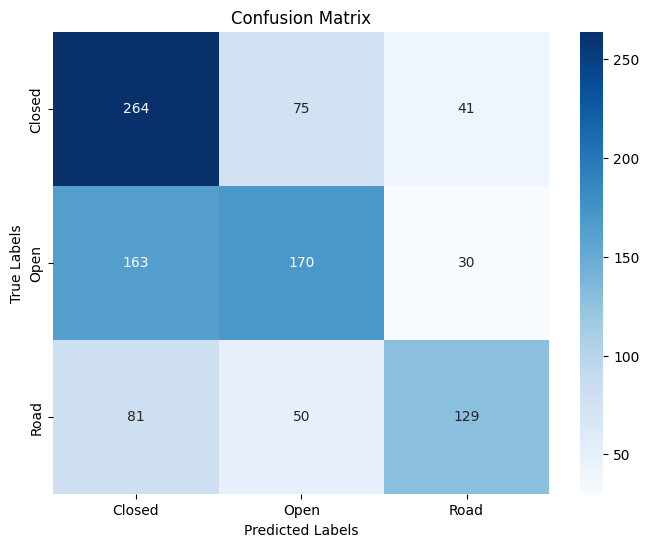

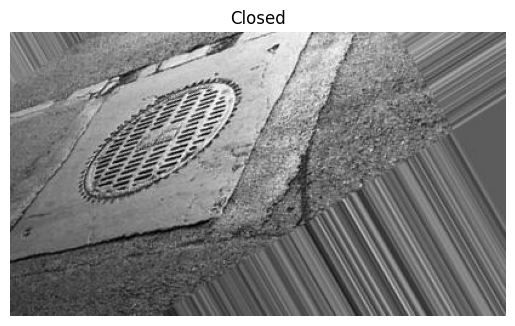

ValueError: ignored

In [ ]:
#SVM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Load and preprocess the data
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')
data_train.shape, labels_train.shape

# Function to preprocess the images for HOG feature extraction
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        img = arr[i]
        # Resize the image to (72, 72)
        img_resized = resize(img, (72, 72), anti_aliasing=True)
        arr_feature.append(img_resized)
    return arr_feature

data_train_p = np.array(preprocessing_part_two(data_train))
data_test_p = np.array(preprocessing_part_two(data_test))

# Function to extract HOG features from the image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return ftr


data_train_ftr = [ExtractHOG(img) for img in data_train_p]
data_test_ftr = [ExtractHOG(img) for img in data_test_p]

# Train the SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(data_train_ftr, labels_train)

# Make predictions and calculate accuracy and F1 score
y_pred = svm_clf.predict(data_test_ftr)
accuracy = accuracy_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred, average='weighted')
print('Test Accuracy:', accuracy * 100, "%")
print('F1 Score:', f1)

# Generate the confusion matrix
cm = confusion_matrix(labels_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Display random test image and its predicted label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

from random import seed
from random import randint
x_ = randint(0, data_test_p.shape[0] - 1)
predicted_label = svm_clf.predict([data_test_ftr[x_]])
predicted_manhole = predicted_label[0]
showImg(data_test[x_], predicted_manhole)

# Load an additional image from a file and make a prediction
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
img = cv2.imread(image_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
img_ftr = ExtractHOG(img_resized)
predicted_label = svm_clf.predict([img_ftr])
predicted_manhole = predicted_label[0]
showImg(img, predicted_manhole)


In [ ]:
#CNN and KNN
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Function to load data from different classes
def load_data(manhole, tipo):
    label=[]
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/"+manhole+"/"+tipo+"/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)

    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels


# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

# Function to preprocess the images for HOG feature extraction
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        img = arr[i]
        # Convert RGB image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Resize the grayscale image
        img_resized = resize(img_gray, (72, 72), anti_aliasing=True)
        arr_feature.append(img_resized)
    return arr_feature

# Function to extract HOG features from the image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False, channel_axis=-1)
    return ftr

# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to train the CNN model
def train_cnn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 1)
    model = create_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=10, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc*100,"%")

    return model, label_encoder

# Function to extract HOG features and train the KNN model
def train_knn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    data_train_ftr = preprocessing_part_two(data_train_p)
    data_test_ftr = preprocessing_part_two(data_test_p)

    knn_clf = KNeighborsClassifier(n_neighbors=3)
    knn_clf.fit(data_train_ftr, labels_train)

    y_pred = knn_clf.predict(data_test_ftr)
    accuracy = accuracy_score(labels_test, y_pred)
    print('Test Accuracy:', accuracy*100,"%")

    return knn_clf

# Function to calculate F1 score for the test set
def calculate_f1_score(labels_true, labels_pred):
    f1 = f1_score(labels_true, labels_pred, average='weighted')
    return f1

# Function to generate the classification report and confusion matrix
def evaluate_classifier(labels_true, labels_pred, class_names):
    f1 = calculate_f1_score(labels_true, labels_pred)
    print('F1 Score:', f1)

    # Generate the classification report
    classification_rep = classification_report(labels_true, labels_pred, target_names=class_names)
    print('Classification Report:')
    print(classification_rep)

    # Generate and plot the confusion matrix
    cm = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to combine CNN and KNN for manhole recognition
def combined_manhole_recognition(image_path):
    # Train CNN and get the model and label encoder
    cnn_model, label_encoder = train_cnn()

    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)

    # Make predictions using CNN
    predicted_labels = cnn_model.predict(img_input)
    predicted_label = np.argmax(predicted_labels)
    predicted_manhole_cnn = label_encoder.inverse_transform([predicted_label])[0]
    showImg(img, predicted_manhole_cnn)

    # Train KNN and get the model
    knn_clf = train_knn()

    # Extract HOG features for the input image
    img_ftr = ExtractHOG(img_resized)

    # Make predictions using KNN
    predicted_label = knn_clf.predict([img_ftr])
    predicted_manhole_knn = predicted_label[0]
    showImg(img, predicted_manhole_knn)

    # Combine CNN and KNN predictions
    # You can use different strategies here, like majority voting or confidence score comparison

    # Display the combined prediction
    combined_prediction = predicted_manhole_cnn if predicted_manhole_cnn == predicted_manhole_knn else "Undecided"
    showImg(img, combined_prediction)

    # Load the test data and preprocess it
    data_test, labels_test = whole_train_data('Test')
    data_test_p = np.array(preprocessing(data_test))
    data_test_p = np.expand_dims(data_test_p, axis=-1)

    # Encode the true labels and make predictions using CNN and KNN on the test set
    labels_test_encoded = label_encoder.transform(labels_test)
    y_pred_cnn = cnn_model.predict(data_test_p)
    y_pred_labels_cnn = np.argmax(y_pred_cnn, axis=1)
    y_pred_knn = knn_clf.predict(preprocessing_part_two(data_test_p))

    # Combine predictions using majority voting
    y_pred_combined = np.array([predicted_manhole_cnn if predicted_manhole_cnn == predicted_manhole_knn else "Undecided" for predicted_manhole_cnn, predicted_manhole_knn in zip(label_encoder.inverse_transform(y_pred_labels_cnn), y_pred_knn)])

    # Evaluate the combined classifier using the generated classification report and confusion matrix
    evaluate_classifier(labels_test_encoded, y_pred_combined, label_encoder.classes_)

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path)


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


NameError: ignored

In [ ]:
#SVM and KNN
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

# Function to extract HOG features from the image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False,channel_axis=-1)
    return ftr
# Function to preprocess the images for HOG feature extraction
def preprocessing_part_two(arr):
    arr_feature = []
    for i in range(np.shape(arr)[0]):
        img = arr[i]
        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Resize the image to (72, 72)
        img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
        arr_feature.append(img_resized)
    return arr_feature


# Function to create the SVM model
def train_svm():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    data_train_ftr = preprocessing_part_two(data_train_p)
    data_test_ftr = preprocessing_part_two(data_test_p)

    svm_clf = SVC(kernel='linear')
    svm_clf.fit(data_train_ftr, labels_train)

    y_pred = svm_clf.predict(data_test_ftr)
    accuracy = accuracy_score(labels_test, y_pred)
    print('SVM Test Accuracy:', accuracy*100, "%")

    # Calculate and display F1 score
    f1 = f1_score(labels_test, y_pred, average='weighted')
    print('SVM F1 Score:', f1)

    # Generate the confusion matrix
    cm = confusion_matrix(labels_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("SVM Confusion Matrix")
    plt.show()

    return svm_clf

# Function to create the KNN model
def train_knn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    data_train_ftr = preprocessing_part_two(data_train_p)
    data_test_ftr = preprocessing_part_two(data_test_p)

    knn_clf = KNeighborsClassifier(n_neighbors=3)
    knn_clf.fit(data_train_ftr, labels_train)

    y_pred = knn_clf.predict(data_test_ftr)
    accuracy = accuracy_score(labels_test, y_pred)
    print('KNN Test Accuracy:', accuracy*100, "%")
    # Calculate and display F1 score
    f1 = f1_score(labels_test, y_pred, average='weighted')
    print('KNN F1 Score:', f1)

    # Generate the confusion matrix
    cm = confusion_matrix(labels_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=knn_clf.classes_, yticklabels=knn_clf.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("KNN Confusion Matrix")
    plt.show()

    return knn_clf
def combined_manhole_recognition(image_path):
    # SVM
    svm_clf = train_svm()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    predicted_label = svm_clf.predict([preprocessing_part_two(img)])
    predicted_manhole_svm = predicted_label[0]
    showImg(img, predicted_manhole_svm)

    # KNN
    knn_clf = train_knn()
    predicted_label = knn_clf.predict([preprocessing_part_two(img)])
    predicted_manhole_knn = predicted_label[0]
    showImg(img, predicted_manhole_knn)

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-08-15 142217.png"
combined_manhole_recognition(image_path)



error: ignored